In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models, transforms
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = 'model\simclr_cifar-10.pth'
checkpoint = torch.load(model_path, map_location=torch.device(device))
model = models.resnet18(pretrained=True)
model.load_state_dict(checkpoint, strict=False)
model.to(device)
model.fc = nn.Identity() 
feature_extractor = model
feature_extractor.eval()

d:\Python Projects\Machine_learning_cw2\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python Projects\Machine_learning_cw2\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [80]:
# Define image transformations (resizing to 32x32 for CIFAR-10)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to CIFAR-10 dimensions
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  # Normalize with CIFAR-10 stats
])

# Load CIFAR-10 dataset
cifar_dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)
# Create a DataLoader for batch processing
data_loader = DataLoader(cifar_dataset, batch_size=128, shuffle=False)

In [81]:
def extract_embeddings():
    # Store embeddings and labels
    all_embeddings = []
    all_labels = []

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for data in data_loader:

            images, labels = data[0].to(device), data[1].to(device)

            # Pass images through feature extractor
            features = feature_extractor(images)  # Output shape: (batch, 512, 1, 1)
            
            # Flatten feature maps (remove extra dimensions)
            features = features.view(features.size(0), -1)  # (batch, 512)

            # L2 Normalize the embeddings
            features = torch.nn.functional.normalize(features, p=2, dim=1)

            # Store results
            all_embeddings.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convert to numpy arrays
    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.concatenate(all_labels)

    return all_embeddings, all_labels


In [82]:
def typiclust(embeddings, labelled_examples = None, B = 10):
    max_clusters = 500
    K_neighbors = 20  # Number of neighbors to consider for density estimation
    
    if labelled_examples is not None:
        selected_examples = labelled_examples
    else:
        selected_examples = []
    
    cumulative_budget = len(selected_examples) + B
    K = min(cumulative_budget, max_clusters)

    # Perform clustering using MiniBatchKMeans for efficiency
    if K <= 50:
        kmeans = KMeans(n_clusters=K, random_state=42)
    else:
        kmeans = MiniBatchKMeans(n_clusters=K, batch_size=256, random_state=42)

    cluster_assignments = kmeans.fit_predict(embeddings)

    # Identify uncovered clusters and their sizes
    uncovered_clusters = []
    for cluster_id in range(K):
        cluster_indices = np.where(cluster_assignments == cluster_id)[0]
        
        # Check if the cluster is uncovered (no overlap with selected examples)
        if set(cluster_indices) & set(selected_examples):
            continue
        
        # Skip clusters with fewer than 5 samples
        if len(cluster_indices) < 5:
            continue
        
        uncovered_clusters.append((cluster_id, len(cluster_indices)))
    
    # Sort uncovered clusters by size in descending order
    uncovered_clusters.sort(key=lambda x: x[1], reverse=True)
    
    # Select the B largest uncovered clusters
    top_B_clusters = [cluster_id for cluster_id, _ in uncovered_clusters[:B]]

    # Select the most typical example from each of the top B clusters
    for cluster_id in top_B_clusters:
        cluster_indices = np.where(cluster_assignments == cluster_id)[0]
        cluster_embeddings = embeddings[cluster_indices]

        # Compute pairwise distances using NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=min(K_neighbors, len(cluster_embeddings))).fit(cluster_embeddings)
        distances, _ = nbrs.kneighbors(cluster_embeddings)

        # Compute typicality as the inverse of average distance to neighbors
        avg_distances = distances.mean(axis=1)
        typicality_scores = 1 / avg_distances

        # Select the most typical example in the cluster
        most_typical_idx = cluster_indices[typicality_scores.argmax()]
        selected_examples.append(most_typical_idx)

    
    return selected_examples

In [83]:
def random_selection(embeddings, labelled_examples = None, B = 10):

    
    if labelled_examples is not None:
        selected_examples = labelled_examples
    else:
        selected_examples = []

    ublabelled_points = list(range(len(embeddings)))
    ublabelled_points = [x for x in ublabelled_points if x not in selected_examples]

    # Randomly select `budget` indices without replacement
    selected_indices = np.random.choice(ublabelled_points, size=B, replace=False)
    
    selected_examples.extend(selected_indices)
    
    return selected_examples

Fully supervised

In [84]:
class TransformSubset(torch.utils.data.Dataset):
    """
    A custom wrapper to apply transformations to a subset of a dataset.
    """
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

def fully_supervised_evaluation(selected_indices, device, epochs=100):
    # Define transformations for training (including augmentation)
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
    ])

    # Load CIFAR-10 dataset
    cifar_dataset = datasets.CIFAR10(root="./data", train=True, transform=None, download=True)
    test_dataset = datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True)

    # Create a subset of CIFAR-10 with selected examples
    selected_subset = Subset(cifar_dataset, selected_indices)

    # Apply transformations only to the subset
    train_dataset = TransformSubset(selected_subset, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Initialize model
    model = models.resnet18(num_classes=10).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, weight_decay=5e-4, nesterov=True)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    # Training function
    def train():
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Testing function
    def test():
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        return accuracy
    
    # Training loop
    best_accuracy = 0.0
    for epoch in range(epochs):  # Increased epochs as per modifications
        train()
        scheduler.step()
        if (epoch + 1) % 10 == 0:  # Test every 10 epochs
            accuracy = test()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
    
    return best_accuracy

Fully Supervised with Linear Embeddings

In [85]:
def fully_supervised_with_linear_embeddings_evaluation(all_embeddings, all_labels, selected_indices, feature_extractor, device, batch_size=128, epochs=200):
    # Create train dataset with selected examples
    train_embeddings = all_embeddings[selected_indices]
    train_labels = all_labels[selected_indices]

    train_dataset = TensorDataset(
        torch.tensor(train_embeddings),
        torch.tensor(train_labels)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Load test dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
    ])
    test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

    # Extract test embeddings using the feature extractor
    test_embeddings = []
    test_labels = []

    with torch.no_grad():
        for images, labels in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
            images = images.to(device)
            features = feature_extractor(images)
            features = features.view(features.size(0), -1)
            features = torch.nn.functional.normalize(features, p=2, dim=1)
            test_embeddings.append(features.cpu().numpy())
            test_labels.append(labels.numpy())

    test_embeddings = np.vstack(test_embeddings)
    test_labels = np.concatenate(test_labels)

    test_dataset = TensorDataset(
        torch.tensor(test_embeddings),
        torch.tensor(test_labels)
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define linear classifier
    input_dim = train_embeddings.shape[1]  # Should be 512 if using ResNet18
    num_classes = 10  # For CIFAR-10
    classifier = nn.Linear(input_dim, num_classes).to(device)

    # Define optimizer and loss function
    optimizer = optim.SGD(classifier.parameters(), lr=2.5, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Training function
    def train():
        classifier.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = classifier(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            

    # Testing function
    def test():
        classifier.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = classifier(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        return accuracy

    # Training loop
    best_accuracy = 0.0
    for epoch in range(epochs):
        train()
        if (epoch + 1) % 10 == 0:
            accuracy = test()
            if accuracy > best_accuracy:
                best_accuracy = accuracy

    # Final evaluation
    print(f"Best Test Accuracy: {best_accuracy:.2f}%")
    return best_accuracy

Semi - Supervised with FlexMatch

In [ ]:
# Define WideResNet architecture (unchanged)
class WideBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(WideBasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(x))
        out = self.conv1(out)
        out = torch.relu(self.bn2(out))
        out = self.conv2(out)
        out += self.shortcut(x)
        return out

class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, num_classes):
        super(WideResNet, self).__init__()
        n_channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert (depth - 4) % 6 == 0, 'depth should be 6n+4'
        n = (depth - 4) // 6
        self.conv1 = nn.Conv2d(3, n_channels[0], kernel_size=3, 
                               padding=1, bias=False)
        self.layer1 = self._make_layer(n, n_channels[0], n_channels[1], 1)
        self.layer2 = self._make_layer(n, n_channels[1], n_channels[2], 2)
        self.layer3 = self._make_layer(n, n_channels[2], n_channels[3], 2)
        self.bn1 = nn.BatchNorm2d(n_channels[3])
        self.fc = nn.Linear(n_channels[3], num_classes)

    def _make_layer(self, n, in_channels, out_channels, stride):
        layers = [WideBasicBlock(in_channels, out_channels, stride)]
        for _ in range(1, n):
            layers.append(WideBasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.relu(self.bn1(out))
        out = torch.mean(out, dim=(2, 3))  # Global average pooling
        out = self.fc(out)
        return out

# Semi-Supervised Evaluation Function
def semi_supervised_evaluation(selected_indices, device, epochs=400, batch_size=64, lr=0.03, weight_decay=0.0005, momentum=0.9, threshold=0.95):
    # Define transformations
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
    ])

    # Load CIFAR-10 dataset
    train_dataset = CIFAR10(root="./data", train=True, transform=transform_train, download=True)
    test_dataset = CIFAR10(root="./data", train=False, transform=transform_test, download=True)

    # Create labeled and unlabeled subsets
    labeled_subset = Subset(train_dataset, selected_indices)
    unlabeled_subset = Subset(train_dataset, list(set(range(len(train_dataset))) - set(selected_indices)))

    labeled_loader = DataLoader(labeled_subset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Initialize WideResNet-28-2
    model = WideResNet(depth=28, widen_factor=2, num_classes=10).to(device)

    # Define optimizer and scheduler
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    criterion = nn.CrossEntropyLoss()

    # Training function with FlexMatch
    def train(unlabeled_loader_iter):
        model.train()
        for batch_idx, (labeled_data, labeled_target) in enumerate(labeled_loader):
            # Get labeled data
            labeled_data, labeled_target = labeled_data.to(device), labeled_target.to(device)

            # Get unlabeled data
            try:
                unlabeled_data, _ = next(unlabeled_loader_iter)
            except StopIteration:
                unlabeled_loader_iter = iter(unlabeled_loader)
                unlabeled_data, _ = next(unlabeled_loader_iter)
            unlabeled_data = unlabeled_data.to(device)

            # Forward pass for labeled data
            labeled_output = model(labeled_data)
            supervised_loss = criterion(labeled_output, labeled_target)

            # Forward pass for unlabeled data (pseudo-labeling)
            unlabeled_output = model(unlabeled_data)
            pseudo_labels = torch.argmax(unlabeled_output, dim=1)
            confidence = torch.max(torch.softmax(unlabeled_output, dim=1), dim=1).values

            # Apply confidence threshold for pseudo-labels
            mask = confidence > threshold
            if mask.sum() > 0:
                unsupervised_loss = criterion(unlabeled_output[mask], pseudo_labels[mask])
            else:
                unsupervised_loss = 0.0

            # Combine losses
            loss = supervised_loss + unsupervised_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()

    # Testing function
    def test():
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

    # Training loop
    unlabeled_loader_iter = iter(unlabeled_loader)
    best_accuracy = 0.0
    for epoch in range(epochs):
        train(unlabeled_loader_iter)
        if (epoch + 1) % 10 == 0:
            accuracy = test()
            if accuracy > best_accuracy:
                best_accuracy = accuracy

    # Final evaluation
    final_accuracy = test()
    return final_accuracy

In [95]:
def plot_accuracy(tpc_acc, rand_acc, title):
    """
    Plots accuracy curves for TypiClust and Random Selection with shaded standard error regions.

    Parameters:
    - tpc_acc: List of lists (or NumPy array) containing accuracy values across multiple trials for TypiClust.
    - rand_acc: List of lists (or NumPy array) containing accuracy values across multiple trials for Random Selection.
    """
    cumulative_budget = [10, 20, 30, 40, 50, 60]

    # Convert lists to NumPy arrays for easier computation
    tpc_acc = np.array(tpc_acc).T
    rand_acc = np.array(rand_acc).T

    # Compute mean and standard error
    tpc_mean = np.mean(tpc_acc, axis=0)
    tpc_std = np.std(tpc_acc, axis=0, ddof=1) / np.sqrt(tpc_acc.shape[0])

    rand_mean = np.mean(rand_acc, axis=0)
    rand_std = np.std(rand_acc, axis=0, ddof=1) / np.sqrt(rand_acc.shape[0])

    # Plot
    plt.figure(figsize=(6, 4))

    # TPC line plot with shaded standard error
    plt.plot(cumulative_budget, tpc_mean, marker='o', linestyle='-', color='blue', label="TypiClust")
    plt.fill_between(cumulative_budget, tpc_mean - tpc_std, tpc_mean + tpc_std, color='blue', alpha=0.2)

    # Random selection line plot with shaded standard error
    plt.plot(cumulative_budget, rand_mean, marker='o', linestyle='-', color='red', label="Random Selection")
    plt.fill_between(cumulative_budget, rand_mean - rand_std, rand_mean + rand_std, color='red', alpha=0.2)

    # Labels and legend
    plt.xlabel("Cumulative Budget")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    # Show plot
    plt.show()


In [88]:
def plot_bar_chart(tpc_acc, rand_acc, title):
    """
    Plots a bar chart comparing TypiClust and Random Selection accuracy across multiple runs.

    Parameters:
    - tpc_acc: List of accuracy values for TypiClust across multiple runs.
    - rand_acc: List of accuracy values for Random Selection across multiple runs.
    - title: (str) Title of the plot.
    """
    # Compute mean and standard deviation
    tpc_mean = np.mean(tpc_acc)
    tpc_std = np.std(tpc_acc, ddof=1)  # ddof=1 for sample standard deviation

    rand_mean = np.mean(rand_acc)
    rand_std = np.std(rand_acc, ddof=1)

    methods = ["Random", "TypiClust"]
    accuracies = [rand_mean, tpc_mean]
    errors = [rand_std, tpc_std]

    colors = ["black", "blue"]

    plt.figure(figsize=(4, 5))
    bars = plt.bar(methods, accuracies, yerr=errors, capsize=5, color=colors, alpha=0.8)

    # Annotate values on top of bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{acc:.1f}", 
                 ha='center', fontsize=12, fontweight='bold')

    plt.ylim(0, 100)
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()

In [89]:
all_embeddings, all_labels = extract_embeddings()

In [ ]:
tpc_acc = [[] for _ in range(6)]
rand_acc = [[] for _ in range(6)]

for _ in range(10):
    # Initial Pool
    tpc_indices = typiclust(all_embeddings)
    rand_indices = random_selection(all_embeddings)

    tpc_acc[0].append(fully_supervised_evaluation(tpc_indices, device))
    rand_acc[0].append(fully_supervised_evaluation(rand_indices, device))

    # Active Learning Iterations
    for i in range(1, 6):
        tpc_indices = typiclust(all_embeddings, tpc_indices)
        rand_indices = random_selection(all_embeddings, rand_indices)

        tpc_acc[i].append(fully_supervised_evaluation(tpc_indices, device))
        rand_acc[i].append(fully_supervised_evaluation(rand_indices, device))




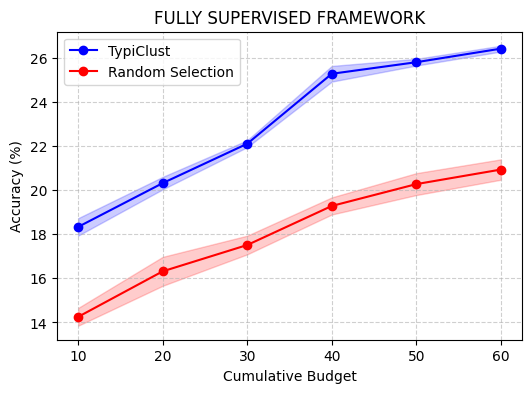

In [96]:
plot_accuracy(tpc_acc, rand_acc, "FULLY SUPERVISED FRAMEWORK")

In [ ]:
tpc_acc = [[] for _ in range(6)]
rand_acc = [[] for _ in range(6)]

for _ in range(10):
    # Initial Pool
    tpc_indices = typiclust(all_embeddings)
    rand_indices = random_selection(all_embeddings)

    tpc_acc[0].append(fully_supervised_with_linear_embeddings_evaluation(all_embeddings, all_labels, tpc_indices, feature_extractor, device))
    rand_acc[0].append(fully_supervised_with_linear_embeddings_evaluation(all_embeddings, all_labels, rand_indices, feature_extractor, device))

    # Active Learning Iterations
    for i in range(1, 6):
        tpc_indices = typiclust(all_embeddings, tpc_indices)
        rand_indices = random_selection(all_embeddings, rand_indices)

        tpc_acc[i].append(fully_supervised_with_linear_embeddings_evaluation(all_embeddings, all_labels, tpc_indices, feature_extractor, device))
        rand_acc[i].append(fully_supervised_with_linear_embeddings_evaluation(all_embeddings, all_labels, rand_indices, feature_extractor, device))
    
plot_accuracy(tpc_acc, rand_acc, title="FULLY SUPERVISED WITH SELF-SUPERVISED EMBEDDING")

In [ ]:
tpc_acc = []
rand_acc = []

for _ in range(3):
    tpc_indices = typiclust(all_embeddings)
    rand_indices = random_selection(all_embeddings)

    tpc_acc.append(semi_supervised_evaluation(tpc_indices, device))
    rand_acc.append(semi_supervised_evaluation(rand_indices, device))

plot_bar_chart(tpc_acc, rand_acc, title="SEMI-SUPERVISED FRAMEWORK")

In [101]:
from scipy.stats import wilcoxon

# Example data
TypiClust_scores = [93.2, 92.8, 93.5, 93.0, 92.9, 93.1, 93.4, 93.3, 93.6, 93.0]
Baseline_scores = [85.6, 86.1, 85.8, 86.0, 85.7, 85.9, 86.2, 86.0, 85.8, 86.1]
# Perform Wilcoxon signed-rank test
w_stat, p_value = wilcoxon(TypiClust_scores, Baseline_scores)

print(f"W-statistic: {w_stat}, P-value: {p_value}")

W-statistic: 0.0, P-value: 0.001953125
